In [ ]:
import numpy as np
import pandas as pd
import config as cfg
from scipy.stats import zscore, sem, t

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({
    'axes.labelsize': 'large',
    'axes.titlesize': 'x-large',  # Set larger title size
    'font.size': 14.0,
    'legend.fontsize': 'medium',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'
})

filename = f"{cfg.RESULTS_DIR}/synthetic_results_wrong_copula.csv"
df = pd.read_csv(filename)

# Define sigma-level (1-sigma/2-sigma)
sigma_level = 2

# Define a threshold for z-scores (commonly 3)
z_threshold = 3

# Apply z-score filtering to numeric columns
columns = ['ci_harrell_error', 'ci_uno_error', 'ci_dep_ipcw_error',
           'ibs_ipcw_error', 'ibs_dep_bg_error', 'mae_margin_error', 'mae_dep_bg_error']
df = df[(zscore(df[columns]) < z_threshold).all(axis=1)]

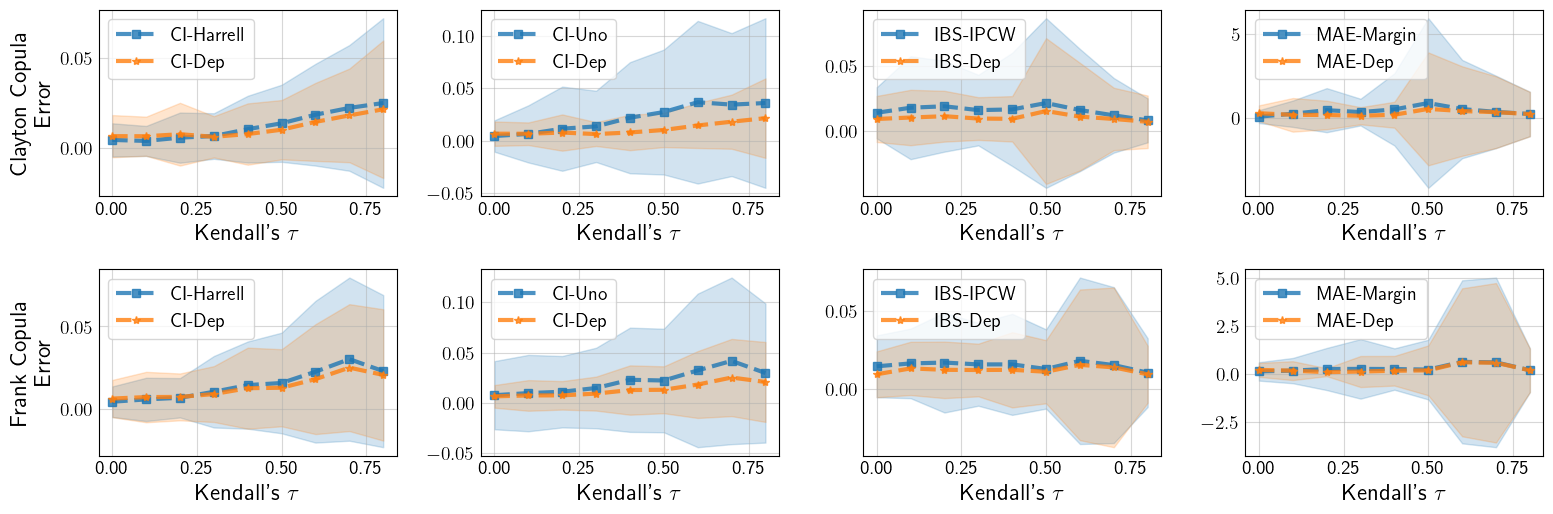

In [2]:
# Group by k_tau and compute the mean and std across seeds
grouped = df.groupby(['copula_name', 'k_tau', 'n_samples'])
mean_errors = grouped.mean().reset_index()
std_errors = grouped.std().reset_index()

# Define the error columns and their plot styles
error_columns = [('ci_harrell_error', "ci_dep_ipcw_error", "CI-Harrell", "CI-Dep"),
                 ("ci_uno_error", "ci_dep_ipcw_error", "CI-Uno", "CI-Dep "),
                 ('ibs_ipcw_error', "ibs_dep_bg_error", "IBS-IPCW", "IBS-Dep"),
                 ('mae_margin_error', "mae_dep_bg_error", "MAE-Margin", "MAE-Dep")]

# Create subplots (2 rows, 4 columns)
fig, axs = plt.subplots(2, 4, figsize=(16, 6))

# Row mapping for Clayton and Frank copulas
copula_rows = {'clayton': 0, 'frank': 1}

# Set n_features
n_samples = 10000
n_features = 10

for col_idx, (indep_metric, dep_metric, indep_metric_name, dep_metric_name) in enumerate(error_columns):
    for copula_name, row_idx in copula_rows.items():
        # Filter data for the current copula and sample size
        copula_data = mean_errors[(mean_errors['copula_name'] == copula_name) & 
                                    (mean_errors['n_samples'] == n_samples)]
        copula_std = std_errors[(std_errors['copula_name'] == copula_name) & 
                                (std_errors['n_samples'] == n_samples)]
        
        # Plot the independent metric with error bars
        axs[row_idx, col_idx].plot(
            copula_data['k_tau'], copula_data[indep_metric],
            linestyle='dashed', marker='s',
            label=indep_metric_name, alpha=0.8, linewidth=3
        )

        axs[row_idx, col_idx].fill_between(
            copula_data['k_tau'],
            copula_data[indep_metric] - sigma_level * copula_std[indep_metric],
            copula_data[indep_metric] + sigma_level * copula_std[indep_metric],
            alpha=0.2, color='tab:blue'  # Use same color as line if you want matching
        )
        
        # Plot the dependent metric with error bars
        axs[row_idx, col_idx].plot(
            copula_data['k_tau'], copula_data[dep_metric],
            linestyle='dashed', marker='*',
            label=dep_metric_name, alpha=0.8, linewidth=3
        )

        axs[row_idx, col_idx].fill_between(
            copula_data['k_tau'],
            copula_data[dep_metric] - sigma_level * copula_std[dep_metric],
            copula_data[dep_metric] + sigma_level * copula_std[dep_metric],
            alpha=0.2, color='tab:orange'
        )
        
        # Set axis labels and titles
        axs[row_idx, col_idx].set_xticks([0.0, 0.25, 0.5, 0.75])
        axs[row_idx, col_idx].set_xticklabels(['0.00', '0.25', '0.50', '0.75'])
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel(f"{copula_name.capitalize()} Copula \n" + "Error") # r"$|$True - Approx.$|$
        axs[row_idx, col_idx].grid(True, alpha=0.5)
        axs[row_idx, col_idx].tick_params(axis='y', which='both', length=0)
        axs[row_idx, col_idx].tick_params(axis='x', which='both', length=0)
        axs[row_idx, col_idx].set_xlabel("Kendall's $\\tau$")
        axs[row_idx, col_idx].legend(loc="upper left")
        
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig(f"{cfg.PLOTS_DIR}/synthetic_wrong_copula_dep.pdf", format='pdf', bbox_inches='tight')
plt.show()